In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.utils import shuffle
import plotly.graph_objects as go
import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/warwick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/warwick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import re
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [3]:
CA_raw_data = pd.read_csv('CAVideos.csv')

In [8]:
CA_n_data = CA_raw_data.shape[0]
feature_list = CA_raw_data.columns
print("the number of CA video data is:", CA_n_data)
print("features are:", feature_list)
print("the number of features are:", len(feature_list))

the number of CA video data is: 40881
features are: Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')
the number of features are: 16


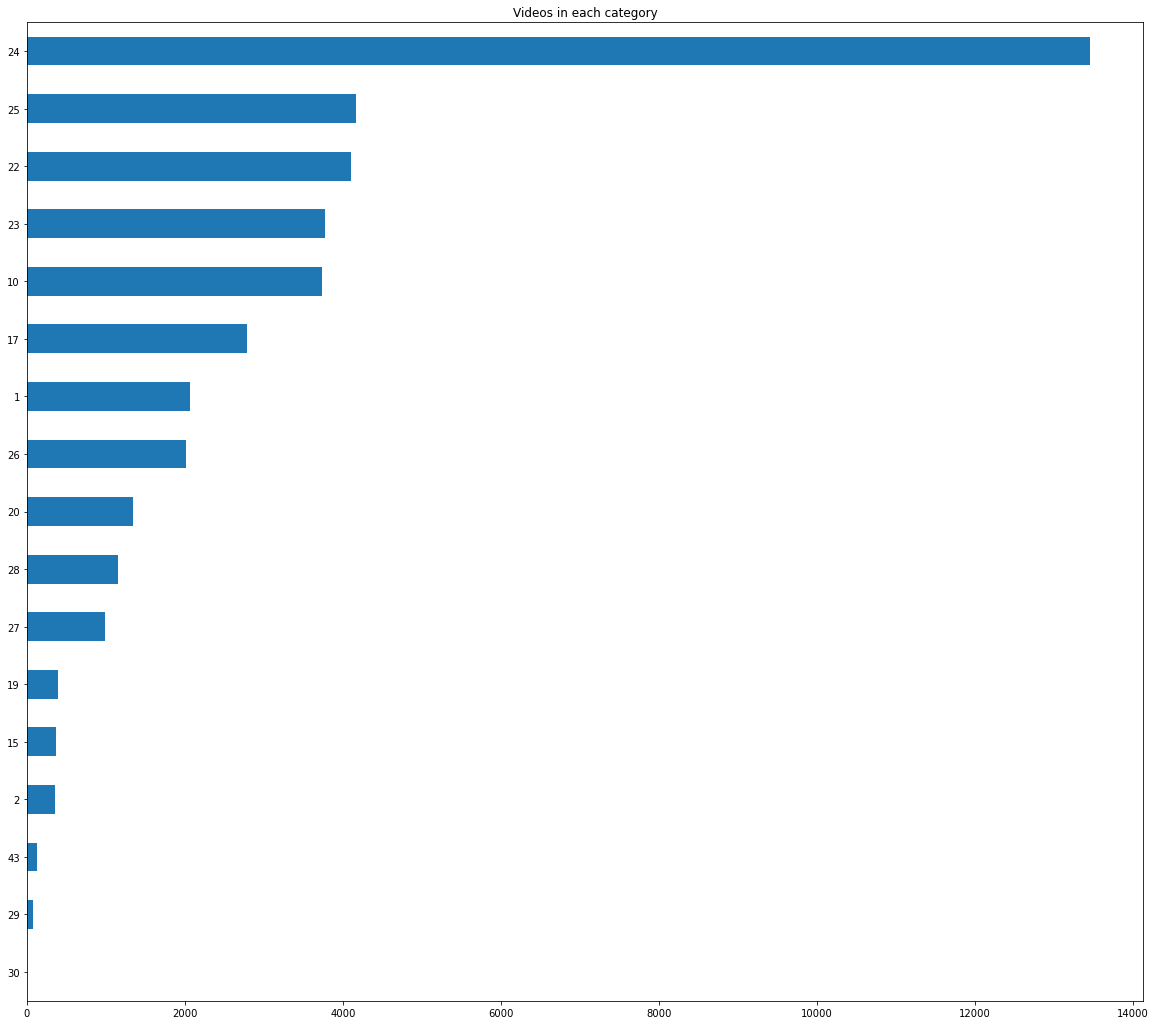

24    13451
25     4159
22     4105
23     3773
10     3731
17     2787
1      2060
26     2007
20     1344
28     1155
27      991
19      392
15      369
2       353
43      124
29       74
30        6
Name: category_id, dtype: int64

In [11]:
CA_raw_data['category_id'].value_counts().sort_values().plot(kind = 'barh', figsize=(20,18))
plt.title("Videos in each category")
plt.show()
CA_raw_data.category_id.value_counts()

In [12]:
CA_raw_data.groupby('category_id')["likes"].describe(percentiles = [0.25, 0.5, 0.75])

,count,mean,std,min,25%,50%,75%,max
category_id,,,,,,,,
1,2060.0,37767.962621,70987.522707,0.0,2048.75,12627.0,36857.25,532660.0
2,353.0,13405.422096,10941.774509,40.0,6030.00,13046.0,18377.00,86125.0
10,3731.0,151285.856339,328600.004233,0.0,14525.00,50958.0,145943.50,5053338.0
15,369.0,23931.533875,32077.061346,215.0,7005.00,15361.0,26265.00,193092.0
17,2787.0,21330.972013,72874.272311,0.0,742.00,3484.0,11295.50,926660.0
19,392.0,9568.658163,9804.743491,4.0,5718.00,8516.0,11447.75,135057.0
20,1344.0,38487.017857,50001.091262,0.0,9397.75,19161.5,44092.00,340240.0
22,4105.0,25673.219001,77922.247662,0.0,1089.00,5372.0,21100.00,1967910.0
23,3773.0,51960.422475,81818.357313,4.0,9502.00,22414.0,55255.00,831516.0


In [13]:
CA_raw_data.groupby('category_id')["dislikes"].describe(percentiles = [0.25, 0.5, 0.75])

,count,mean,std,min,25%,50%,75%,max
category_id,,,,,,,,
1,2060.0,1510.319903,4061.595323,0.0,80.00,317.5,1217.25,60025.0
2,353.0,560.271955,1308.636710,1.0,107.00,299.0,630.00,12290.0
10,3731.0,5922.859823,14501.969267,0.0,343.00,1285.0,4302.00,165854.0
15,369.0,501.363144,750.668936,5.0,120.00,248.0,541.00,7732.0
17,2787.0,1179.177969,7104.915671,0.0,42.00,185.0,556.50,164693.0
19,392.0,331.278061,636.718350,0.0,126.75,200.0,296.25,7688.0
20,1344.0,1820.596726,7532.210015,0.0,125.00,297.0,1164.00,174645.0
22,4105.0,2309.572716,17390.768079,0.0,65.00,207.0,681.00,504340.0
23,3773.0,1423.937185,2932.410482,0.0,206.00,518.0,1317.00,43698.0


In [14]:
CA_raw_data.groupby('category_id')["views"].describe(percentiles = [0.25, 0.5, 0.75])

,count,mean,std,min,25%,50%,75%,max
category_id,,,,,,,,
1,2060.0,1.426729e+06,3.049511e+06,2274.0,142946.50,460852.0,1332658.50,27696924.0
2,353.0,5.667594e+05,1.063534e+06,3059.0,195600.00,391515.0,652655.00,11004698.0
10,3731.0,3.532525e+06,6.912860e+06,3201.0,406941.50,1216670.0,3419619.50,98938809.0
15,369.0,6.384612e+05,9.460588e+05,8171.0,173681.00,337492.0,644233.00,5954189.0
17,2787.0,1.075584e+06,2.341431e+06,1023.0,115669.50,390040.0,989238.50,24117244.0
19,392.0,3.667014e+05,4.699737e+05,3144.0,175546.25,264524.5,371420.75,4169455.0
20,1344.0,9.237592e+05,1.417617e+06,3494.0,204769.50,411583.0,1067033.00,14589314.0
22,4105.0,7.864136e+05,2.145615e+06,1187.0,100327.00,270925.0,699447.00,51243149.0
23,3773.0,9.828886e+05,1.207964e+06,1295.0,271385.00,583684.0,1229430.00,14228882.0


In [ ]:
#try to implement K-mean clustering on 

In [ ]:
category_dict = defaultdict(dict)
for i in 